In [1]:
## 上传一个表格，自动找到与目标列最相关的因子 ##

# 超参数
COLS_Y = 'shipper_split_fill_volume'

# 读取excel文件并获取指定列
import pandas as pd
#df = pd.read_csv('Data\gas_download_202408061717.csv', encoding='GBK')
df = pd.read_csv('Data/gas_download_202408061717.csv')
print(df.dtypes)

id                            int64
data_date                    object
ou_name                      object
name                         object
pipeline_name                object
station_name                 object
client_name                  object
shipper_name                 object
shipper_split_fill_volume     int64
dw_month                      int64
dw_day                        int64
dtype: object


In [2]:
## 转换分类变量 ##

# 函数：判断列是否为分类变量，并转换为哑变量
def convert_categorical_to_dummy(dataframe):
    # 存储转换后的DataFrame
    new_df = dataframe.copy()
    
    # 遍历DataFrame中的列
    for column in new_df.columns:
        # 检查列的数据类型
        if new_df[column].dtype == 'object':
            # 检查列中的值是否只包含数字（尝试转换为整数）
            if new_df[column].apply(lambda x: str(x).isdigit() if isinstance(x, str) else False).all():
                # 全是数字的话直接转换为int64
                #new_df[column] = new_df[column].astype(int)
                print(f"数字列 '{column}' was converted to int64.")
            else:
                # 尝试转换为日期时间格式
                try:
                    datetime_col = pd.to_datetime(new_df[column], format='%Y-%m-%d', errors='raise')
                    # 如果转换成功，转换为Unix时间戳（秒级）并转换为int64
                    if not datetime_col.isnull().all():
                        new_df[column] = (datetime_col - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
                        print(f"日期列 '{column}' was converted to Unix timestamp int64.")
                except ValueError:
                    # 如果转换失败，视为分类变量，则将分类变量转换为哑变量
                    #print(f"分类列 '{column}' will be converted to dummy variables.")
                    #new_df = pd.get_dummies(new_df, columns=[column], drop_first=True)
                    
                    # 对每个分类变量进行均值编码
                    # 计算每个类别的平均目标值
                    group_means = dataframe.groupby(column)[COLS_Y].mean()
                    
                    # 用目标变量的平均值替换原始的类别值
                    new_df[column] = new_df[column].map(group_means)
                    
                    # 如果类别在group_means中不存在，则设置一个默认值（例如目标变量的平均值）
                    default_value = group_means.mean()
                    new_df[column].fillna(default_value)
                    
                    # 打印转换信息
                    print(f"分类列 '{column}' was mean-encoded.")
    return new_df
df_converted = convert_categorical_to_dummy(df)
# print(df_converted.dtypes)
# print(df_converted)

日期列 'data_date' was converted to Unix timestamp int64.
分类列 'ou_name' was mean-encoded.
分类列 'name' was mean-encoded.
分类列 'pipeline_name' was mean-encoded.
分类列 'station_name' was mean-encoded.
分类列 'client_name' was mean-encoded.
分类列 'shipper_name' was mean-encoded.


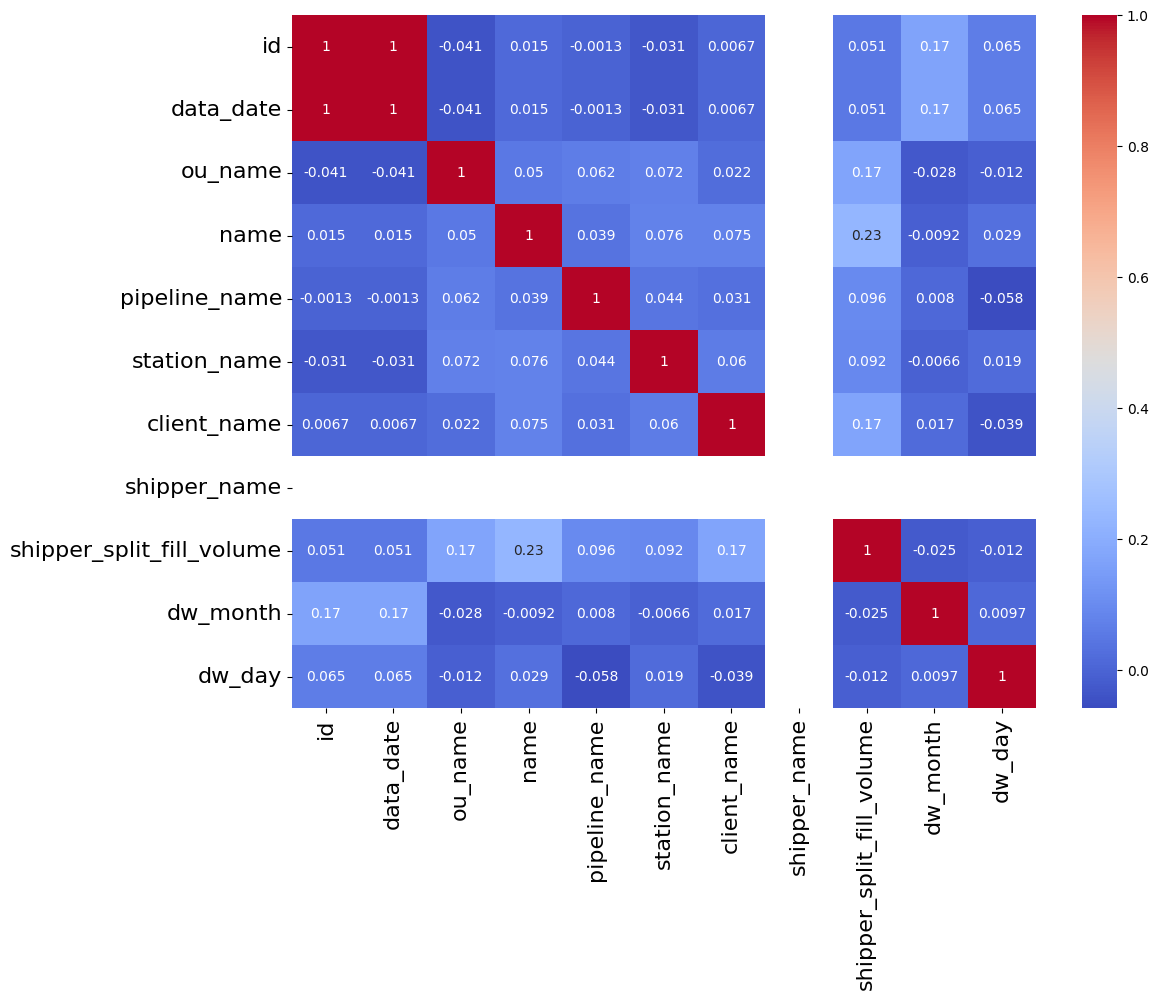

In [3]:
## 展示相关性热图 ##
# 计算相关系数
correlation_matrix = df_converted.corr()

# 绘制热图
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图像大小
plt.figure(figsize=(12, 9)) 

# 设置坐标轴标签字体大小
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [5]:
from scipy.stats import pearsonr
import numpy as np

# 返回前X个最相关因子
def find_top_factors(dataframe, target_column, num_top_factors):
    correlations = {}
    for column in dataframe.columns:
        if column != target_column:
            # 检查列是否为常数列
            if np.var(dataframe[column]) == 0:
                print(f"常数列 '{column}' is a constant column and will be skipped corr caculate.")
                continue  # 跳过常数列
            
            # 计算相关性
            corr, _ = pearsonr(dataframe[target_column], dataframe[column])
            correlations[column] = corr

    # 根据相关性排序，取绝对值，因为我们想要的是影响大小，不是方向
    #sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True).
    sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
    
    # 返回影响最大的前三列因子
    return [factor for factor, _ in sorted_correlations[:num_top_factors]]


# 找到对列A影响最大的前三列因子
top_factors = find_top_factors(df_converted, COLS_Y, 3)

print("Top 3 影响列： ", top_factors)

常数列 'shipper_name' is a constant column and will be skipped corr caculate.
Top 3 影响列：  ['name', 'client_name', 'ou_name']
